# ***Regresion e introduccion método de Boosting***

## ***Universidad Central***

## ***Maestría en analítica de datos***

## ***Métodos estadísticos para analítica de datos.***

## ***Docente: Luis Andrés Campos Maldonado.***

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos-Estadisticos/main/data/"

## _**[DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html)**_

### ***Predicción de una valor continuo.***

Predecir un valor continuo (también denominado regresión) con un árbol sigue la misma lógica y procedimiento que en una clasificación binaria, excepto que la impureza se mide por desviaciones al cuadrado de la media (errores cuadráticos) en cada subpartición, y el rendimiento predictivo se juzga por
la raíz cuadrada del error cuadrático medio (RMSE) en cada partición. scikit-learn tiene la clase [`sklearn.tree.DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) para entrenar un modelo de regresión del árbol de decisión.

Cuando se usan los árboles, uno de los grandes obstáculos que se enfrentan los modeladores predictivos es la naturaleza percibida de "caja negra" de los métodos que utilizan. En este sentido, el modelo de Decision Tree tiene dos
aspectos atractivos:

• Los Decision Tree proporcionan una herramienta visual para explorar los datos, para tener una idea de que variables son importantes y cómo se relacionan entre sí. Los árboles pueden capturar relaciones no lineales entre variables predictoras.

• Los Decision Tree proporcionan un conjunto de reglas que se pueden comunicar de manera efectiva a
especialistas, ya sea para la implementación o para “vender” un proyecto de analitica de datos.

Sin embargo, cuando se trata de predicción, aprovechar los resultados de múltiples árboles es típicamente más poderoso que usar un solo árbol. En particular, _Random Forrest_  casi siempre brindan una precisión predictiva superior y rendimiento, pero se pierden las mencionadas ventajas de un solo árbol.

***Ideas importantes:***


1. Los Decision Tree producen un conjunto de reglas para clasificar o predecir un resultado.

2. Las reglas corresponden a particiones sucesivas de los datos en subparticiones.

3. Cada partición, o división, hace referencia a un valor específico de una variable predictora y divide los datos en registros donde el valor del predictor está por encima o por debajo de ese valor dividido.

4. En cada etapa, el algoritmo de Decision Tree seleciona la división que minimiza el resultado de impureza dentro de cada subpartición.

5. La asiganación de la predicción se realiza siguiendo el camino que el árbol va indicando.

6. Un árbol completamente desarrollado sobreajusta (_overfitting_) los datos y debe ser podado para que capture señal y no ruido.

7. Los algoritmos como los _Random Forrest_ y árboles potenciados (_boosting_), ofrecen un mejor rendimiento predictivo, pero pierden el poder comunicativo basado en reglas de los algoritmos de Decision Tree.

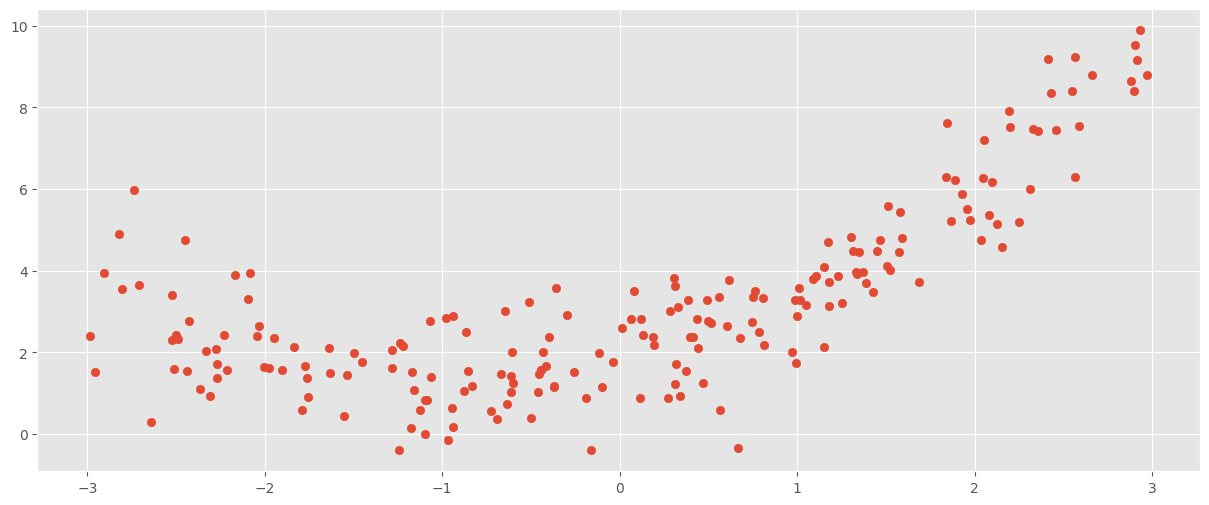

In [2]:
# Simulemos unos datos con relación cuadrática.
np.random.seed(123)
m = 200
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
df = pd.DataFrame(np.hstack((X, y)), columns=['regresor', 'y'])
plt.scatter(X,y)
plt.show()

R2 score in LR: 0.473364
R2 score in tree model: 0.7781


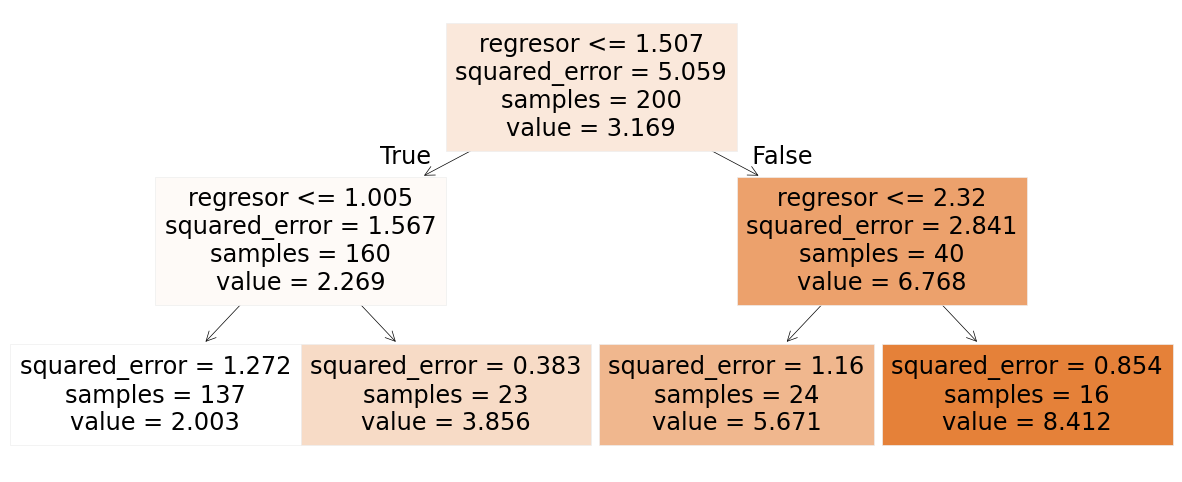

In [3]:
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=123)
tree_reg.fit(X, y)

print(f"R2 score in LR: {LinearRegression().fit(X, y).score(X, y):4f}")
print(f"R2 score in tree model: {tree_reg.score(X, y):.4f}")

plot_tree(tree_reg, filled=True, feature_names=df.drop(columns=["y"]).columns)
plt.show()

Este árbol se parece mucho al árbol de clasificación que ya conocemos. La principal diferencia es que en lugar de predecir una clase en cada nodo, predice un valor. Como ejemplo, supongamos que deseamos hacer una predicción para $x_0=2.15$, luego se debe atravezar el árbol comenzando en la raíz, y finalmente llegando al nodo hoja y el `value` que se predice es 5.671. Esta predicción es simplemente el valor objetivo promedio de la variable target en 24 registros del set de train que quedarón allí. Además esta predicción da como media del error (MSE) (`squared_error`) 1.16 sobre estos 24 registros.

El algoritmo CART funciona casi de la misma manera que antes, excepto que en lugar de tratar de dividir el set de train de una manera que minimice la impureza, ahora trata de dividir el set de train de una manera que minimice el MSE. La función de costo que el algoritmo intenta minimizar es:

$$J(k,t_k)=\frac{m_{left}}{m}MSE_{left}+\frac{m_{right}}{m}MSE_{rigth}$$

Donde:

1. $MSE_{node}=\frac{1}{m_{mode}}\displaystyle\sum_{i\in\ \ node}(\hat{y}_{node}-y^{(i)})^{2}$

2. $\hat{y}_{node}=\frac{1}{m_{node_i}}\displaystyle\sum_{i \in \ \ node}y^{(i)}$


Al igual que para las tareas de clasificación, los árboles de decisión tienden a tener `overfitting` cuando se trata con tareas de regresión. Sin ninguna regularización (es decir, utilizando el valor predeterminado hiperparámetros), es bastante probable que su algoritmo este con `overfitting`.

In [4]:
# Nodo Raiz
print("\nPara el nodo raiz:")
y_mean = df["y"].mean()
print(f"value = {y_mean:.3f}")
print(f"squared_error = {mean_squared_error(df['y'], [y_mean] * len(df)):.3f}")
print(f"Numero de muestras= {len(df)}")

# Para el primer split
print("\nPara el primer split:")
y_left = df.query("regresor <= 1.507")[["y"]]
y_right = df.query("regresor > 1.507")[["y"]]

y_left_mean = np.mean(y_left)
y_right_mean = np.mean(y_right)
m_left = len(y_left)
m_right = len(y_right)
m_total = m_left + m_right

print(f"Instancias nodo izquiero = {m_left:.3f}")
print(f"Instancias nodo derecho = {m_right:.3f}")
print(f"Instancias nodo padre = {m_total:.3f}")


mse_left = mean_squared_error(y_left, [y_left_mean] * len(y_left))
mse_right = mean_squared_error(y_right, [y_right_mean] * len(y_right))
print(f"\nMSE nodo izquierdo = {mse_left:.3f}")
print(f"MSE nodo derecho = {mse_right:.3f}")

mse_total = (m_left / m_total) * mse_left + (m_right / m_total) * mse_right

print(f"\nMSE ponderado para los nodos izquierdo y derecho: {mse_total:.3f}")


Para el nodo raiz:
value = 3.169
squared_error = 5.059
Numero de muestras= 200

Para el primer split:
Instancias nodo izquiero = 160.000
Instancias nodo derecho = 40.000
Instancias nodo padre = 200.000

MSE nodo izquierdo = 1.567
MSE nodo derecho = 2.841

MSE ponderado para los nodos izquierdo y derecho: 1.821


***Nota.***

Los árboles priorizan los límites de decisión ortogonales (todas las divisiones son perpendiculares a un eje), esto los hace sensibles a la rotación del set de train. Una forma de limitar problemas que cortes innecesarios (piense en rotar un región en 45 grados)
es usar PCA, que a menudo resulta en una mejor orientación en el set de train.

## ***Ejemplo 1.***

### ***Modelos con DecisionTreeRegressor.***

In [5]:
df_house = pd.read_csv(url_base + "kc_house_data.csv")
df_to_model = df_house.copy()
df_to_model = df_to_model.drop(columns=["id", "sqft_living15", "sqft_lot15", "date"])
df_to_model["renovated"] = df_to_model["yr_renovated"] > 0
df_to_model.drop(columns=["yr_renovated"], inplace=True)
df_to_model.drop_duplicates(inplace=True)
df_to_model.info()
df_to_model

<class 'pandas.core.frame.DataFrame'>
Index: 21608 entries, 0 to 21612
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21608 non-null  float64
 1   bedrooms       21608 non-null  int64  
 2   bathrooms      21608 non-null  float64
 3   sqft_living    21608 non-null  int64  
 4   sqft_lot       21608 non-null  int64  
 5   floors         21608 non-null  float64
 6   waterfront     21608 non-null  int64  
 7   view           21608 non-null  int64  
 8   condition      21608 non-null  int64  
 9   grade          21608 non-null  int64  
 10  sqft_above     21608 non-null  int64  
 11  sqft_basement  21608 non-null  int64  
 12  yr_built       21608 non-null  int64  
 13  zipcode        21608 non-null  int64  
 14  lat            21608 non-null  float64
 15  long           21608 non-null  float64
 16  renovated      21608 non-null  bool   
dtypes: bool(1), float64(5), int64(11)
memory usage: 2.8 MB


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,renovated
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,47.5112,-122.257,False
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,47.7210,-122.319,True
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,98028,47.7379,-122.233,False
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,47.5208,-122.393,False
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,47.6168,-122.045,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,98103,47.6993,-122.346,False
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,98146,47.5107,-122.362,False
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,98144,47.5944,-122.299,False
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,98027,47.5345,-122.069,False


In [6]:
X = df_to_model.drop(columns=["price"])
y = df_to_model["price"]

features_categoric = ["waterfront", "zipcode", "view", "renovated", "grade"]
numerical_columns = [col for col in X.columns if col not in features_categoric]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_categoric),
        ("num", "passthrough", numerical_columns)
    ]
)

tree_model = DecisionTreeRegressor()

pipeline_tree = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", tree_model)
])

pipeline_tree.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['waterfront', 'zipcode',
                                                   'view', 'renovated',
                                                   'grade']),
                                                 ('num', 'passthrough',
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'condition',
                                                   'sqft_above',
                                                   'sqft_basement', 'yr_built',
                                                   'lat', 'long'])])),
                ('model', DecisionTreeRegressor())])

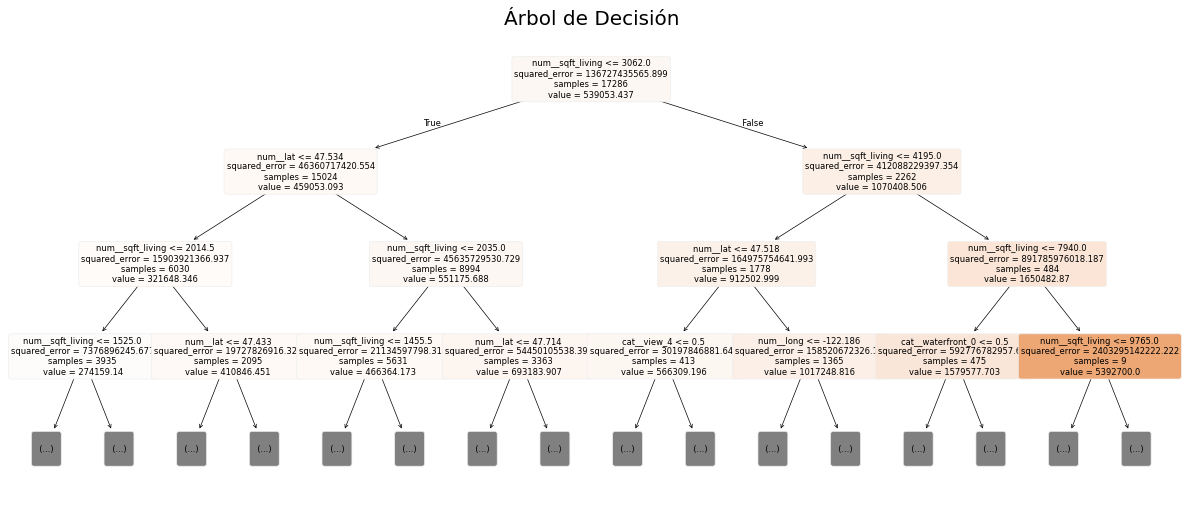

In [7]:
tree_model = pipeline_tree.named_steps["model"]

plt.figure(figsize=(15, 6))
plot_tree(
    tree_model,
    feature_names=pipeline_tree.named_steps["preprocessor"].get_feature_names_out(),
    max_depth=3,
    filled=True,
    rounded=True,
    fontsize=6
)
plt.title("Árbol de Decisión")
plt.show()

In [8]:
print("Overfitting!!!")
print(f"R2 en Train: {pipeline_tree.score(X_train, y_train):.4f}")
print(f"R2 en Test:  {pipeline_tree.score(X_test, y_test):.4f}")

Overfitting!!!
R2 en Train: 0.9992
R2 en Test:  0.6527


In [9]:
# Buscando los "mejores" parámetros para Decision Tree
params = {
    "model__max_depth": [n + 2 for n in range(9)],
    "model__criterion": ["squared_error", "absolute_error", "friedman_mse"] ,
    "model__min_samples_split" : [10 + 10 * n for n in range(30)]
}

random_search_tree = RandomizedSearchCV(
    pipeline_tree,
    param_distributions=params,
    cv=5,
    n_jobs=-1,
    random_state=123,
)

search_tree = random_search_tree.fit(X_train, y_train)

print(f"'Best' params:")
pprint(search_tree.best_params_)
print(f'\nR^2 en TRAIN: {search_tree.best_estimator_.score(X_train, y_train):.4f}')
print(f'R^2 en TEST:  {search_tree.best_estimator_.score(X_test, y_test):.4f}')

'Best' params:
{'model__criterion': 'friedman_mse',
 'model__max_depth': 9,
 'model__min_samples_split': 60}

R^2 en TRAIN: 0.8466
R^2 en TEST:  0.7537


### ***Modelo con RandomForestRegressor.***

In [10]:
# 2 mins corriendo
rf_model = RandomForestRegressor()

pipeline_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_model)
])

pipeline_rf.fit(X_train, y_train)

print("Overfitting!!!")
print(f"R2 en Train: {pipeline_rf.score(X_train, y_train):.4f}")
print(f"R2 en Test:  {pipeline_rf.score(X_test, y_test):.4f}")

Overfitting!!!


R2 en Train: 0.9828
R2 en Test:  0.8496


In [11]:
# 2 min corriendo
rf_model1 = RandomForestRegressor(
    max_depth=12,
    min_samples_split=50,
    n_estimators=150    
)

pipeline_rf1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_model1)
])

pipeline_rf1.fit(X_train, y_train)

print(pipeline_rf1.score(X_train, y_train))
print(pipeline_rf1.score(X_test, y_test))

0.8983077356735792
0.8316341191697778


In [12]:
# Buscando los "mejores" parámetros para Random Forrest
base_estimator_rf = RandomForestRegressor()

pipeline_rf_best = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_estimator_rf)
])


params = {
    "model__max_depth": [4, 5, 6, 8, 10], 
    "model__criterion": ["squared_error", "absolute_error", "friedman_mse"],
    "model__min_samples_split": [50 + 25 * n for n in range(10)],
    "model__max_features": ["sqrt", "log2", 10],
    "model__n_estimators": [100 + 50 * n for n in range(10)]
}
      
search_regressor_rf = RandomizedSearchCV(
    pipeline_rf_best,
    params,
    n_iter=1,
    cv=5,
    n_jobs=-1,
    verbose=3,
    return_train_score=True
)

search_rf = search_regressor_rf.fit(X_train, y_train)

print("'Best' params:")
pprint(search_rf.best_params_)
print(f"\nR2 en Train: {search_rf.best_estimator_.score(X_train, y_train):.4f}")
print(f"R2 en Test:  {search_rf.best_estimator_.score(X_test, y_test):.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


'Best' params:
{'model__criterion': 'squared_error',
 'model__max_depth': 10,
 'model__max_features': 'sqrt',
 'model__min_samples_split': 275,
 'model__n_estimators': 450}



R2 en Train: 0.7415
R2 en Test:  0.7334


In [13]:
# Guardamos resultamos para analisis posteriores.
pd.DataFrame(search_regressor_rf.cv_results_)##.to_csv("data/rf_cv_grid_results.csv", index=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__min_samples_split,param_model__max_features,param_model__max_depth,param_model__criterion,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,10.072852,0.122756,0.167918,0.001057,450,275,sqrt,10,squared_error,"{'model__n_estimators': 450, 'model__min_sampl...",...,0.709249,0.024515,1,0.727819,0.731267,0.730608,0.731713,0.728273,0.729936,0.001589


In [14]:
rf_model_best = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    max_features=15,
    min_samples_split=50
)

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_model_best)
])

rf_pipeline.fit(X_train, y_train)

print(f"R2 en Train: {rf_pipeline.score(X_train, y_train):.4f}")
print(f"R2 en Test:  {rf_pipeline.score(X_test, y_test):.4f}")

R2 en Train: 0.8398
R2 en Test:  0.7946


#### ***Ejercicio***

Reconstruya el mismo modelo con regresion lineal multiple, compare metricas, discuta.

# ***Boosting. (Impulsar)***

Los modelos de ensemble son una herramienta estándar para el modelado predictivo. ***Boosting*** es un técnica general para crear un modelo de un conjunto de modelos. Como ***bagging***, ***boosting*** se usa más comúnmente con árboles de decisión. A pesar de sus similitudes, ***boosting*** toma un enfoque muy diferente. Como resultado, mientras que ***bagging*** se puede hacer con relativamente poca afinación, ***boosting*** requiere mucho mayor cuidado en su aplicación. Si estos dos métodos fueran coches, ***bagging*** podría considerarse un Honda Accord (confiable y estable), mientras que impulsar podría ser considerado un Porsche (potente pero requiere más cuidados).

En los modelos de regresión lineal, los residuales se examinan para buscar mejorar el ajuste. ***Boosting*** toma este concepto y va mucho más allá, a diferencia del ***bagging***, que promedia predicciones independientes de modelos, ***boosting*** construye modelos secuenciales que corrigen los errores del anterior. El Boosting es un enfoque iterativo que combina múltiples modelos base (habitualmente débiles) para construir un modelo de ***ensemble*** fuerte.



### ***Planteamiento del problema de optimización que se va a resolver con Gradient Boosting***

#### ***Contexto***

En el contexto de la **regresión**, nuestro objetivo es encontrar una función $F(x)$ que, dada una entrada $x$, prediga un valor $y$ lo más cercano posible al valor real observado. En términos de ***optimización***, queremos ajustar esta función para que minimice el error entre las predicciones y los valores reales.

Matemáticamente, tenemos:

$$\hat{y_i} = F(x_i)$$

Donde:

- $y_i$ es el valor real observado.
- $\hat{y_i} = F(x_i)$ es la predicción de la función $F(x)$ para el punto $x_i$.

El objetivo es ***minimizar la diferencia*** entre las predicciones $F(x_i)$ y los valores reales $y_i$, lo que se puede expresar como:

$$\text{Minimizar} \ \mathcal{L}(F(x), y) = \frac{1}{n} \sum_{i=1}^n (y_i - F(x_i))^2$$

Este es el problema de optimización clásico de la ***minimización del Error Cuadrático Medio (MSE)***.

#### ***¿Cómo resolver el problema de optimización?***

Una forma directa de resolver este problema es utilizar un ***algoritmo de optimización*** que actualice las predicciones de manera iterativa para minimizar la función de pérdida.

El ***Gradient Boosting*** resuelve este problema ***iterativamente***. Ajusta una ***serie de modelos*** (típicamente árboles de decisión) que, en cada paso, ***corrigen los errores*** cometidos por el modelo previo. En lugar de ajustar todos los parámetros de una vez (como en la regresión lineal), ***Gradient Boosting*** ajusta pequeñas correcciones a las predicciones de manera secuencial, optimizando en cada iteración para reducir el error en la dirección correcta.

#### ***La derivada de la función de pérdida***


El gradiente es una medida de la pendiente de la función de pérdida y nos indica la dirección en la que debemos movernos para reducir el error. Asi, para resolver el problema de optimización, necesitamos calcular el gradiente de la función de pérdida con respecto a las predicciones $F(x)$. Esto nos permitirá saber cómo actualizar nuestras predicciones en cada iteración del algoritmo de ***Gradient Boosting***.

En este caso, la función de pérdida que estamos utilizando es el **Error Cuadrático Medio (MSE)**:

$$\mathcal{L}(F(x), y) = \frac{1}{n} \sum_{i=1}^n (y_i - F(x_i))^2$$

Donde:

- $y_i$ es el valor real observado para el punto $x_i$.
- $F(x_i)$ es la predicción que estamos haciendo para el punto $x_i$.

El objetivo es **minimizar** esta función de pérdida con respecto a las predicciones $F(x_i)$. Para eso, necesitamos **derivar** la función de pérdida con respecto a las predicciones $F(x_i)$ y obtener el gradiente, que nos indica la dirección en la que debemos mover nuestras predicciones para reducir el error.

#### ***Derivada de MSE***

Para calcular la derivada de la MSE con respecto a $F(x_i)$, aplicamos las reglas de derivación:

$$\frac{\partial}{\partial F(x_i)} \mathcal{L}(F(x), y) = \frac{\partial}{\partial F(x_i)} \left( \frac{1}{n} \sum_{i=1}^n (y_i - F(x_i))^2 \right)$$

Al derivar la expresión, obtenemos:

$$\frac{\partial}{\partial F(x_i)} \mathcal{L}(F(x), y) \varpropto - (y_i - F(x_i))$$

#### ***Interpretación del gradiente***

El gradiente de la función de pérdida en este caso es el **residuo** entre el valor real $y_i$ y la predicción $F(x_i)$:

$$\text{Gradiente} \varpropto -(y_i - F(x_i))$$

Este valor nos indica cuánto y en qué dirección debemos ajustar nuestras predicciones $F(x_i)$ para minimizar el error. Si el gradiente es positivo, eso significa que la predicción $F(x_i)$ es menor que $y_i$, por lo que debemos aumentar la predicción. Si el gradiente es negativo, eso significa que la predicción $F(x_i)$ es mayor que $y_i$, por lo que debemos disminuirla.

En **Gradient Boosting**, utilizamos este gradiente para **ajustar nuestras predicciones** en cada iteración, corrigiendo los errores de los modelos anteriores.


### ***Algoritmo de Gradient Boosting***

#### ***Pasos del algoritmo***

1. **Inicialización**
   - Definir el número máximo de iteraciones $M$.
   - Inicializar el modelo del _ensemble_ $\hat{F}_0(x)$ como una constante, que típicamente es la media de las observaciones de $y$, es decir, $\hat{F}_0(x) = \text{media}(y)$.
   - Inicializar los residuos $r_i^{(0)} = y_i - \hat{F}_0(x_i)$, que son las diferencias entre los valores reales y las predicciones iniciales.

2. **Iteración**  
   Para $m = 1, 2, \dots, M$:

   - **Entrenar un modelo base** $\hat{f}_m(x)$:
     - Entrenar un modelo base $\hat{f}_m(x)$ (por ejemplo, un árbol de decisión) para predecir los residuos o gradientes. Este modelo debe minimizar la función de pérdida en los residuos, de modo que:
     
       $$\hat{f}_m(x) = \text{modelo base ajustado sobre los residuos}$$
     - En lugar de ajustarse directamente sobre los valores originales de $y$, el modelo base se ajusta sobre los residuos, que son el gradiente de la función de pérdida con respecto a las predicciones actuales $\hat{F}_{m-1}(x)$.

   - **Actualizar el modelo del _ensemble_**:
     - Actualizar el modelo $\hat{F}_m(x)$ combinando la predicción del modelo base $\hat{f}_m(x)$ con la predicción anterior $\hat{F}_{m-1}(x)$ utilizando un coeficiente de aprendizaje $\nu$:
     
       $$\hat{F}_m(x) = \hat{F}_{m-1}(x) + \nu \cdot \hat{f}_m(x)$$
     - Aquí, $\nu$ es el coeficiente de aprendizaje que controla la magnitud de la actualización en cada paso.

   - **Actualizar los residuos**:
     - Los nuevos residuos se actualizan como las diferencias entre los valores reales $y_i$ y las nuevas predicciones $\hat{F}_m(x_i)$, es decir:

       $$r_i^{(m)} = y_i - \hat{F}_m(x_i)$$
     - Los residuos son utilizados para la próxima iteración, donde se ajusta un nuevo modelo base $\hat{f}_{m+1}(x)$ sobre estos residuos.

3. **Determinación del criterio de parada**
   - Si se alcanza $m = M$ o si no hay mejora significativa en la función de pérdida entre iteraciones, el proceso de iteración se detiene.

4. **Predicción final**
   - La predicción final del modelo de Boosting es la suma ponderada de los modelos base entrenados en cada iteración:
     $$\hat{F}(x) = \hat{F}_0(x) + \sum_{m=1}^M \nu \cdot \hat{f}_m(x)
     $$
   - Aquí, $\hat{F}_0(x)$ es el modelo inicial (la media en el caso de regresión), y $\nu \cdot \hat{f}_m(x)$ son las contribuciones de los modelos base entrenados en cada iteración.


### ***Modelo con GradientBoosting.***

In [15]:
df_house = pd.read_csv(url_base + "kc_house_data.csv")
df_to_model = df_house.copy()
df_to_model = df_to_model.drop(columns=["id", "sqft_living15", "sqft_lot15", "date"])
df_to_model["renovated"] = df_to_model["yr_renovated"] > 0
df_to_model.drop(columns=["yr_renovated"], inplace=True)
df_to_model.drop_duplicates(inplace=True)

X = df_to_model.drop(columns=["price"])
y = df_to_model["price"]

features_categoric = ["waterfront", "zipcode", "view", "renovated", "grade"]
numerical_columns = [col for col in X.columns if col not in features_categoric]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_categoric),
        ("num", "passthrough", numerical_columns)
    ]
)

gboost = GradientBoostingRegressor()

pipeline_gboost = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model_gdb", gboost)
])

pipeline_gboost.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['waterfront', 'zipcode',
                                                   'view', 'renovated',
                                                   'grade']),
                                                 ('num', 'passthrough',
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'condition',
                                                   'sqft_above',
                                                   'sqft_basement', 'yr_built',
                                                   'lat', 'long'])])),
                ('model_gdb', GradientBoostingRegressor())])

In [16]:
print(pipeline_gboost.score(X_train, y_train))
print(pipeline_gboost.score(X_test, y_test))

0.9002812020273169
0.8295639432067976


### ***Desglose del Algoritmo***

In [17]:
# Primeros tres arboles.
first_tree = pipeline_gboost.named_steps["model_gdb"].estimators_[0, 0]
second_tree = pipeline_gboost.named_steps["model_gdb"].estimators_[1, 0]
third_tree = pipeline_gboost.named_steps["model_gdb"].estimators_[2, 0]

# Predicciones acumuladas en Train
staged_predictions_train = list(pipeline_gboost.named_steps["model_gdb"].staged_predict(
    pipeline_gboost.named_steps["preprocessor"].transform(X_train)
))

# Predicciones acumuladas en Test
staged_predictions_test = pipeline_gboost.named_steps["model_gdb"].staged_predict(
    pipeline_gboost.named_steps["preprocessor"].transform(X_test)
)

#### ***Estimador basico inicial: la media de y_train***

In [18]:
# Primer estimador la media de y_train (paso 0).
y_mean = y_train.mean()
residuals_initial = y_train - y_mean
print("\nResiduos iniciales:")
print(residuals_initial)
mse_inicial = mean_squared_error(y_train, residuals_initial)
print(f"\nMSE inicial = {mse_inicial:,.3f}")


Residuos iniciales:
4136     160946.563404
3584    -209053.436596
10888    -76553.436596
5020     259696.563404
17426    235946.563404
             ...      
15380   -164053.436596
21607    -64053.436596
17733    -41053.436596
15728     55946.563404
19969    310946.563404
Name: price, Length: 17286, dtype: float64

MSE inicial = 290,578,607,506.054


#### ***Mejorardo la media como primer estimador con un arbol***

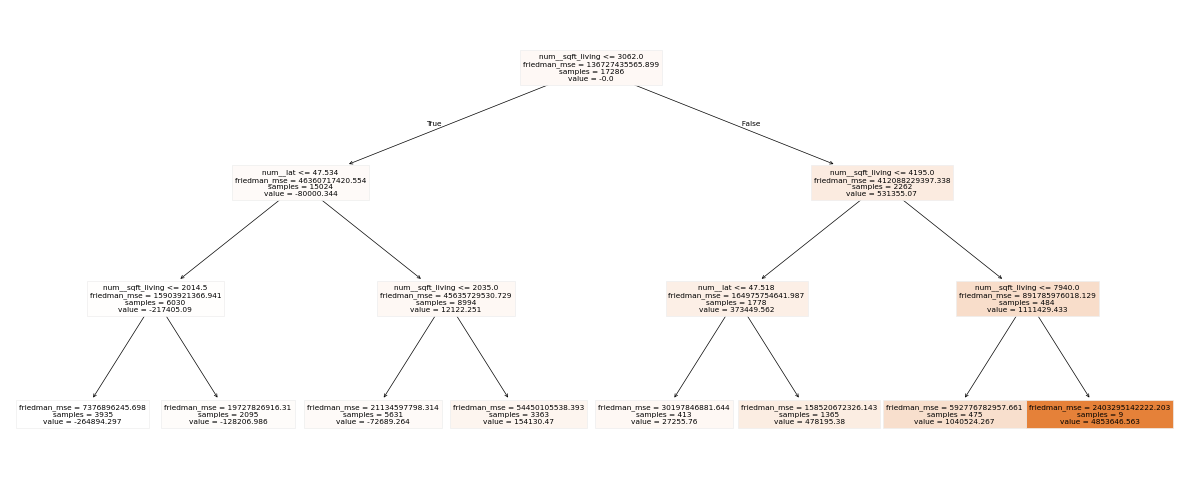

In [19]:
# Primer Arbol
plot_tree(first_tree, filled=True, feature_names=preprocessor.get_feature_names_out())
plt.show()

In [20]:
# Predicciones del primer arbol estimando los residuos.
first_tree.predict(preprocessor.transform(X_train))

array([ 478195.37952113, -128206.98599944,  -72689.26380263, ...,
        -72689.26380263,  -72689.26380263,  -72689.26380263])

In [21]:
# Actualizamos valores
predictions_stage_1 = [y_mean]*len(X_train) + 0.1 * first_tree.predict(preprocessor.transform(X_train))
display(predictions_stage_1)
mse_paso_1 =  mean_squared_error(y_train, predictions_stage_1)
print(f"\nMSE paso 1 = {mse_paso_1:,.3f}")
print(mse_inicial > mse_paso_1)

array([586872.9745482 , 526232.73799615, 531784.51021583, ...,
       531784.51021583, 531784.51021583, 531784.51021583])


MSE paso 1 = 120,691,452,215.075
True


#### ***Segundo arbol***

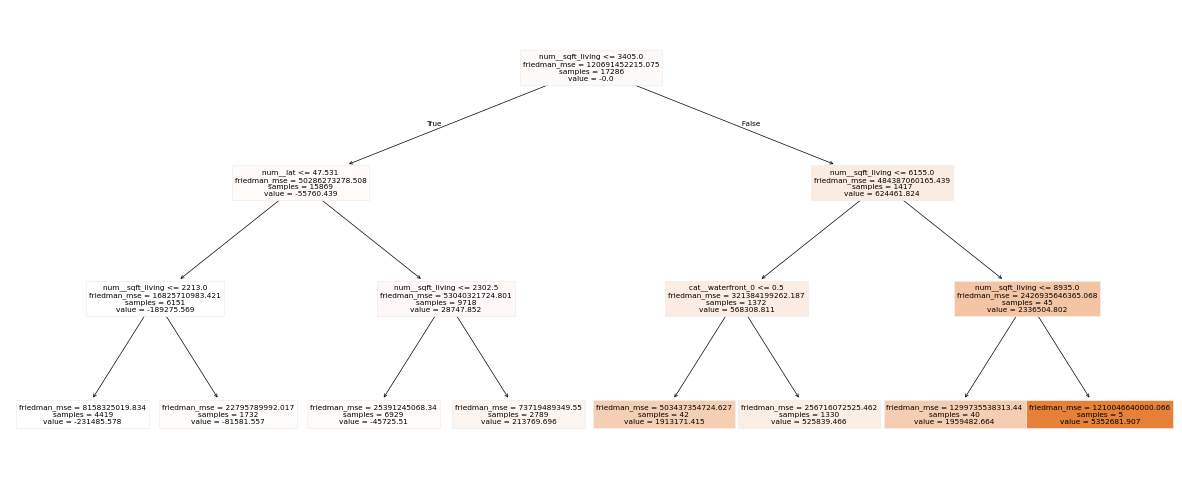

In [22]:
# Segundo Arbol
plot_tree(second_tree, filled=True, feature_names=preprocessor.get_feature_names_out())
plt.show()

In [23]:
# Elementos del arbol 2.
y_step2 = y_train -  predictions_stage_1 # Nuevos residuos a modelar
predict_tree_2 = second_tree.predict(preprocessor.transform(X_train))
# Segundo arbol prediciendo los nuevos residuos y actualizando prediccion
predictions_stage_2  = predictions_stage_1 + 0.1 * second_tree.predict(preprocessor.transform(X_train))
display(predictions_stage_2)  # coincide con: staged_predictions_train[2]
mse_paso_2 = mean_squared_error(y_train, predictions_stage_2)
print(f"\nMSE paso 2 = {mse_paso_2:,.3f}")
print(mse_paso_1 > mse_paso_2)

array([608249.9441467 , 518074.58227838, 527211.95918512, ...,
       527211.95918512, 527211.95918512, 527211.95918512])


MSE paso 2 = 107,407,252,535.312
True


#### ***Tercer arbol***

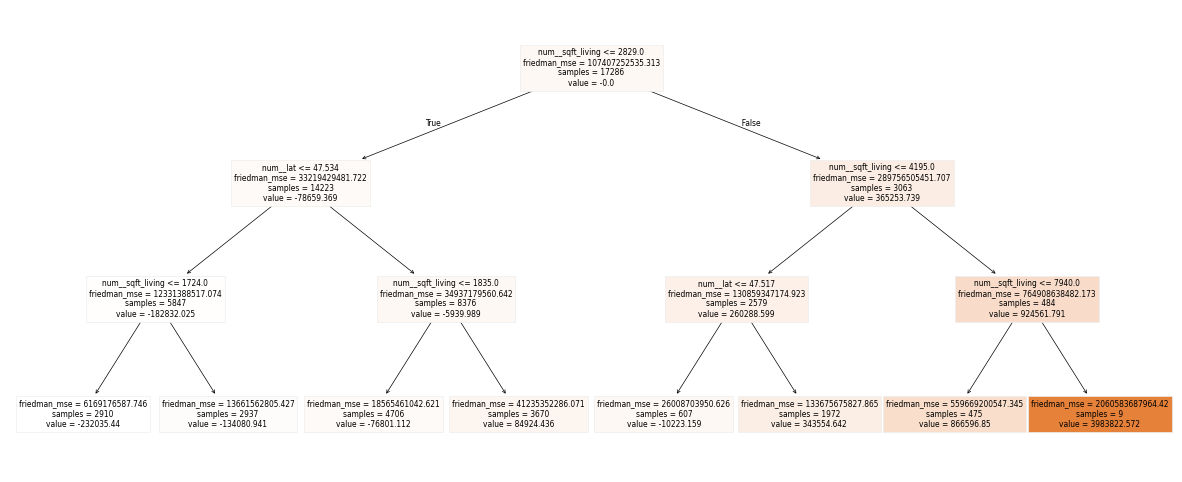

In [24]:
# Tercer Arbol
plot_tree(third_tree, filled=True, feature_names=preprocessor.get_feature_names_out())
plt.show()

In [25]:
# Elementos del arbol 3.
y_step3 = y_train -  predictions_stage_2 # Nuevos residuos a modelar
predict_tree_3 = third_tree.predict(preprocessor.transform(X_train))
# Segundo arbol prediciendo los nuevos residuos y actualizando prediccion
predictions_stage_3  = predictions_stage_2 + 0.1 * third_tree.predict(preprocessor.transform(X_train))
display(predictions_stage_3)  # coincide con: staged_predictions_train[1]
mse_paso_3 =  mean_squared_error(y_train, predictions_stage_3)
print(f"\nMSE paso 3 = {mse_paso_3:,.3f}")
print(mse_paso_2 > mse_paso_3)

array([642605.40833618, 504666.48822322, 519531.84800949, ...,
       519531.84800949, 519531.84800949, 519531.84800949])


MSE paso 3 = 96,458,798,631.760
True


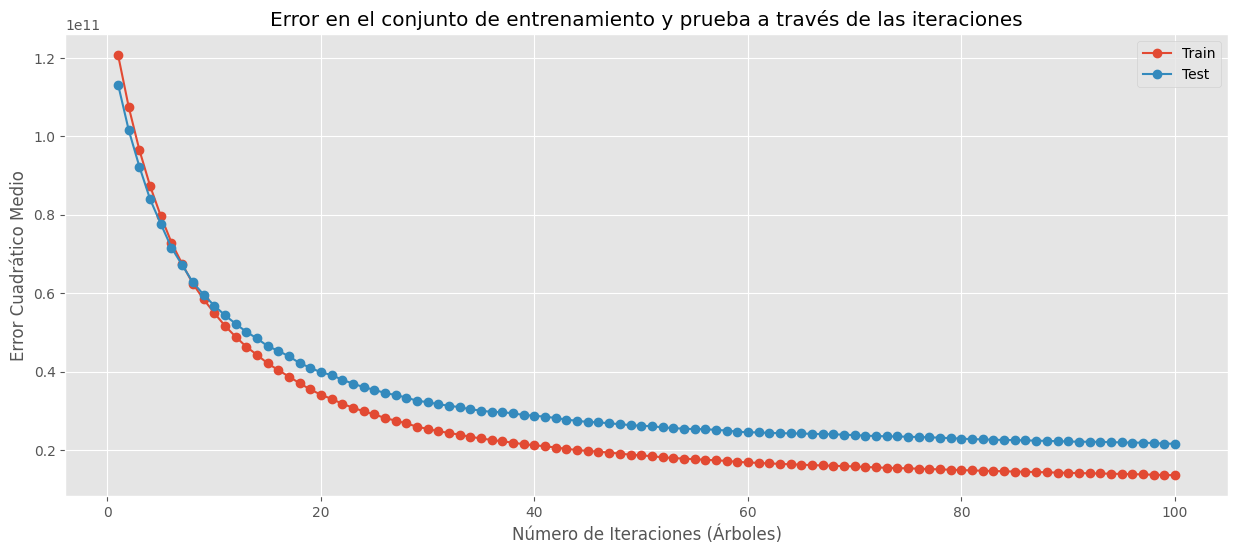

In [26]:
errors_train = np.zeros(100)
errors_test = np.zeros(100)

for i, (pred_train, pred_test) in enumerate(zip(staged_predictions_train, staged_predictions_test)):
    errors_train[i] = mean_squared_error(y_train, pred_train)
    errors_test[i] = mean_squared_error(y_test, pred_test)

plt.plot(range(1, 101), errors_train, marker="o", label="Train")
plt.plot(range(1, 101), errors_test, marker="o", label="Test")
plt.title("Error en el conjunto de entrenamiento y prueba a través de las iteraciones")
plt.xlabel("Número de Iteraciones (Árboles)")
plt.ylabel("Error Cuadrático Medio")
plt.legend()
plt.show()

#### ***Busqueda de Hiperparametros en GradientBoostingRegressor***

In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_categoric),
        ("num", "passthrough", numerical_columns)
    ]
)

gboost = GradientBoostingRegressor()

pipeline_gboost = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model_gdb", gboost)
])

pipeline_gboost.fit(X_train, y_train)

param_grid = {
    "model_gdb__n_estimators": [100, 200, 300, 350, 400],
    "model_gdb__learning_rate": [0.075, 0.01, 0.02, 0.05, 0.1],
    "model_gdb__max_depth": [3, 4, 5, 6, 8, 10],
    "model_gdb__min_samples_split": [2, 5, 8, 10],
    "model_gdb__min_samples_leaf": [50, 100, 150],
    "model_gdb__max_features": ["sqrt", "log2", 15]
}

grid_search_gboost = RandomizedSearchCV(
    pipeline_gboost,
    param_grid,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    verbose=3,
    return_train_score=True
)

grid_search_gboost.fit(X_train, y_train)
print(grid_search_gboost.best_params_)
print(grid_search_gboost.best_estimator_.score(X_train, y_train))
print(grid_search_gboost.best_estimator_.score(X_test, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'model_gdb__n_estimators': 300, 'model_gdb__min_samples_split': 10, 'model_gdb__min_samples_leaf': 150, 'model_gdb__max_features': 15, 'model_gdb__max_depth': 6, 'model_gdb__learning_rate': 0.1}


0.8824483207085242
0.8459171102032405


In [28]:
# Guardamos resultamos para analisis posteriores.
pd.DataFrame(grid_search_gboost.cv_results_)##.to_csv("data/gboost_grid_cv_search.csv", index=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model_gdb__n_estimators,param_model_gdb__min_samples_split,param_model_gdb__min_samples_leaf,param_model_gdb__max_features,param_model_gdb__max_depth,param_model_gdb__learning_rate,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,10.869767,0.249367,0.214011,0.014267,300,10,150,15,6,0.100,...,0.844537,0.015910,1,0.883986,0.880814,0.875576,0.872855,0.876157,0.877877,0.003986
1,4.335061,0.128841,0.136629,0.007425,200,5,100,sqrt,5,0.010,...,0.656871,0.023568,9,0.674738,0.667741,0.665358,0.665773,0.664883,0.667699,0.003652
2,4.228828,0.206974,0.167349,0.038354,350,2,100,log2,4,0.050,...,0.802422,0.024198,6,0.830547,0.821690,0.813767,0.815031,0.825061,0.821219,0.006258
3,9.851146,0.302519,0.416168,0.084687,400,10,100,log2,8,0.050,...,0.834211,0.022647,4,0.869694,0.859838,0.852368,0.860805,0.863552,0.861251,0.005616
4,5.302224,0.236569,0.195824,0.024977,200,5,150,log2,10,0.050,...,0.795120,0.020426,7,0.818642,0.813166,0.811642,0.805665,0.805052,0.810833,0.005044
5,1.958225,0.098546,0.042073,0.001938,100,5,100,15,3,0.075,...,0.782772,0.025474,8,0.811829,0.794273,0.790564,0.795127,0.793477,0.797054,0.007545
6,3.178132,0.111445,0.109587,0.006329,200,10,50,log2,5,0.100,...,0.844287,0.017855,2,0.882164,0.872292,0.867235,0.865677,0.870595,0.871592,0.005783
7,10.968051,0.466411,0.241322,0.021487,350,10,100,sqrt,8,0.020,...,0.809606,0.024413,5,0.843196,0.831655,0.818595,0.827981,0.830507,0.830387,0.007881
8,11.402387,0.371135,0.121713,0.015403,200,10,50,15,10,0.020,...,0.835564,0.024635,3,0.873793,0.861289,0.858168,0.857429,0.863579,0.862852,0.005900
9,2.045443,0.202478,0.049456,0.004184,100,2,150,sqrt,4,0.020,...,0.609198,0.018344,10,0.632046,0.621355,0.609324,0.612823,0.610908,0.617291,0.008467
